## Imports

In [330]:
import pandas as pd
import numpy as np
import string
import re
import contractions
from textblob import TextBlob
from spellchecker import SpellChecker

In [331]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [332]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Input

from keras.models import Sequential, Model

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.optimizers import RMSprop

In [333]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

In [334]:
import matplotlib.pyplot as plt

In [335]:
from mlxtend.plotting import plot_confusion_matrix

In [336]:
import time

In [337]:
from wordcloud import WordCloud

## Load Data and explore to understand

In [338]:
data = pd.read_csv(r"C:\Users\soitb\OneDrive\Desktop\Datasets\twitter_sentiments\training.1600000.processed.noemoticon.csv",  encoding="latin-1")

In [339]:
data.head(3)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire


In [340]:
data.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

Since the header is not provided, we pass our own list of column names

In [428]:
data = pd.read_csv(r"C:\Users\soitb\OneDrive\Desktop\Datasets\twitter_sentiments\training.1600000.processed.noemoticon.csv",  encoding="latin-1", header=None, names=["target","ids","date","flag","user","text"])

In [429]:
data.head(3)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [430]:
data.shape

(1600000, 6)

In [431]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Target column has two distinct values 0 and 4, 0 is for negative sentiment and 4 is for positive sentiment.

Also looking at the value counts for each class(0 and 4), we can say the data is balanced so no need for balancing further

In [432]:
data["target"].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [433]:
data.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

There is no null values present in dataset (so no need to handle null values)

In [434]:
data.isnull().any()

target    False
ids       False
date      False
flag      False
user      False
text      False
dtype: bool

## Data Cleaning and Preprocessing

Selecting the two useful columns namely 1. Target and 2. Text

In [435]:
data.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [436]:
data = data[['target','text']]

Setting the target value = 4 to 1

In [437]:
data['target'][data['target']==4]=1

For now we are taking 1/4th of the data of both classes to train our model (will further see how the change in data size affects the model accuracy)

In [438]:
data_positive = data[data['target']==1].iloc[:80000]
data_negative = data[data['target']==0].iloc[:80000]

In [439]:
print(data_positive.shape)
print(data_negative.shape)

(80000, 2)
(80000, 2)


In [440]:
data_positive.head(2)

,target,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...


concating the whole dataset again to combine both classes in one dataset

In [441]:
data = pd.concat([data_positive,data_negative],axis=0,ignore_index=True)
print(data.shape)

(160000, 2)


In [442]:
data.head(2)

,target,text
0,1,I LOVE @Health4UandPets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...


In [443]:
n = 6
print(data['text'][n])
print(len(data['text'][n]))
print(data['target'][n])

@r_keith_hill Thans for your response. Ihad already find this answer 
69
1


### Data Cleaning

Before cleaning the text i am making a copy of data frame to compare later

In [444]:
data_c = data.copy(deep=True)

In [445]:
id(data)

2767340768144

In [446]:
id(data_c)

2769321619600

Looking at some of the text data it contains:
- web address (www. or https)
- Hashtags #GoWithTheFlow
- numerics
- alpha-numerics
- Upper case and lower case
- Punctuations
- @switchfoot kind of tagging
- repeating words like 'haaappppyyyyy', 'soooooo much', 'Thanksss', 'nooooo'
- Emoticons
- words like u for you and r for are 

Some preprocessings for text:
- lower case
- Punctuations removal
- Stopwords removal except for the 'not', 'shouldn't' didn't etc, as these words changes the sentiment of a text
- 

Converting everything to lower case for uniformity of same words presented in both upper and lower case

In [447]:
data_c['text'] = data_c['text'].apply(lambda x: x.lower())

In [448]:
data_c.head(5)

,target,text
0,1,i love @health4uandpets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...
2,1,"@darealsunisakim thanks for the twitter add, s..."
3,1,being sick can be really cheap when it hurts t...
4,1,@lovesbrooklyn2 he has that effect on everyone


Removing Hashtags

In [449]:
def remove_hashtags(text):
    return re.sub('#[^\s]+', '', text)

In [450]:
data_c['text'] = data_c['text'].apply(lambda x: remove_hashtags(x))

In [451]:
data_c.head(5)

,target,text
0,1,i love @health4uandpets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...
2,1,"@darealsunisakim thanks for the twitter add, s..."
3,1,being sick can be really cheap when it hurts t...
4,1,@lovesbrooklyn2 he has that effect on everyone


Removing usernames like @twitter

In [452]:
def remove_username(text):
    #text = str(text)
    return re.sub('@\w+?\s', '', text)

In [453]:
remove_username('I LOVE @Health4UandPets u guys r the')

'I LOVE u guys r the'

In [454]:
data_c['text'] = data_c['text'].apply(lambda x: remove_username(x))

In [455]:
data.head(2)

,target,text
0,1,I LOVE @Health4UandPets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...


In [456]:
data_c.head(2)

,target,text
0,1,i love u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...


Removing web addresses

In [457]:
def remove_urls(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)

In [458]:
data_c['text'] = data_c['text'].apply(lambda x: remove_urls(x))

In [459]:
data_c.head(5)

,target,text
0,1,i love u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...
2,1,"thanks for the twitter add, sunisa! i got to m..."
3,1,being sick can be really cheap when it hurts t...
4,1,he has that effect on everyone


Using contractions library (i'm --> i am, "wont" --> "will not", "dont"-->"do not" etc.)

In [460]:
data_c['text'] = data_c['text'].apply(lambda x: contractions.fix(x))

In [461]:
data_c.head(5)

,target,text
0,1,i love you guys r the best!!
1,1,i am meeting up with one of my besties tonight...
2,1,"thanks for the twitter add, sunisa! i got to m..."
3,1,being sick can be really cheap when it hurts t...
4,1,he has that effect on everyone


Punctuations removal

Remember that removing all the punctuations will remove all the emmoticons too (like :) :-) :( etc, so if all the punctuations are removed we cant leverage the emoticons for sentiments.

I have to find a way to solve for this problem. ?

In [462]:
def remove_punct(text):
    english_punctuations = string.punctuation
    translator = str.maketrans('','', english_punctuations)
    return text.translate(translator)

In [463]:
data_c['text'] = data_c['text'].apply(lambda x: remove_punct(x))

In [464]:
data_c.head(5)

,target,text
0,1,i love you guys r the best
1,1,i am meeting up with one of my besties tonight...
2,1,thanks for the twitter add sunisa i got to mee...
3,1,being sick can be really cheap when it hurts t...
4,1,he has that effect on everyone


Removing numbers (as numbers doesn't seem to add any sentiments to a sentence)

In [465]:
def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

In [466]:
data_c['text'] = data_c['text'].apply(lambda x: remove_numbers(x))

In [467]:
data_c.head(5)

,target,text
0,1,i love you guys r the best
1,1,i am meeting up with one of my besties tonight...
2,1,thanks for the twitter add sunisa i got to mee...
3,1,being sick can be really cheap when it hurts t...
4,1,he has that effect on everyone


Removing Extra Spaces from text

In [468]:
def remove_extra_spaces(text):
    return re.sub(r'\s\s+', ' ', text)

In [469]:
data_c['text'] = data_c['text'].apply(lambda x: remove_extra_spaces(x))

Spelling correction

In english there is no more than two repeated characters in correct spellings, So removing the more than two repeated characters adn replacing them with only two repeated characters using regex

In [470]:
def remove_repeated_char(text,n):
    n = str(n)
    pattern = r'([a-z])\1{' + n + r',}'
    out_pattern = r'\1\1'
    return re.sub(pattern, out_pattern, text)

In [471]:
data_c['text'] = data_c['text'].apply(lambda x: remove_repeated_char(x,2))

In [472]:
remove_repeated_char('haaappy',2)

'haappy'

Corecting spellings using TextBlob library

Since pyspellchecker and textblob are almost same but for the word 'guys', textblob outputs 'guns' and pyspellchecker outputs 'guys' and 'checker'-->'checked' in textblob and 'checker'-->'checker' in pyspellchecker , I am going with pyspellchecker as it seems more accurate. though they both converted 'plz' to 'ply'.

Note: Pyspellchecker returns none for the unknown words and that causes a problem
and Both of the spellchecker programs are taking so much time which is why i am ignoring sppell check for now

In [473]:
# def spell_correct_tb(x):
#     b = TextBlob(x)
#     return str(b.correct())

In [474]:
# def spell_correct_py(x):
#     spell = SpellChecker()
#     c = [spell.correction(y) for y in x.split()]
#     #print(c)
#     return ' '.join(c)

removing single characters from text

In [475]:
def remove_single(text):
    return re.sub(r'\b[a-z]\s','',text)

In [476]:
data_c['text'] = data_c['text'].apply(lambda x: remove_single(x))

Stop Words handeling

I am including 'no' and 'not' in the stopwords as they affect the sentiment of a text,
Since we already performed contraction, i can leave "won't" "wouldn't" "doesn't" "don't" etc

In [477]:
stopwords_list = set(stopwords.words('english'))
stop_words = set(stopwords.words('english')) - set(['not', 'no',])
#print(stop_words)

In [478]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [479]:
data_c['text'] = data_c['text'].apply(lambda text: remove_stopwords(text))

In [480]:
data_c['text'][0]

'love guys best'

In [481]:
data['text'][0]

'I LOVE @Health4UandPets u guys r the best!! '

In [482]:
data_c[data_c.target == 1].text

0                                           love guys best
1        meeting one besties tonight cannot wait girl talk
2        thanks twitter add sunisa got meet hin show dc...
3        sick really cheap hurts much eat real food plu...
4                                          effect everyone
                               ...                        
79995    morn waitin sun reappear cool not havin chase ...
79996                          still good grief good night
79997    morning world taking parents meal today ahem f...
79998                             drive ins funjust saying
79999                         like twitter page background
Name: text, Length: 80000, dtype: object

In [483]:
#data_c

In [484]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_c[data_c.target == 1].text))
# plt.imshow(wc , interpolation = 'bilinear')

In [485]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_c[data_c.target == 0].text))
# plt.imshow(wc , interpolation = 'bilinear')

Lemmatization to convert words to their roots

I will not use lemmatization here (though will see how it affects the output in future) as pointed out in this paper "The Role of Pre-processing in Twitter Sentiment Analysis" by Yanwei Bao, Changqin Quan, Lijuan Wang, Fuji Ren (Our experiments results on Stanford Twitter Sentiment
Dataset show that URLs features reservation, negation transformation and repeated
letters normalization have a positive impact on classification accuracy while stemming and lemmatization have a negative impact. )(https://kd.nsfc.gov.cn/paperDownload/1000013535999.pdf) 

In [486]:
# lemmatizer = WordNetLemmatizer()
# def lemmatize_text(data):
#     text = [lemmatizer.lemmatize(word) for word in data]
#     return data

## Preparation for Modeling

### Tokenization

There is something called nltk.tokenize.TweetTokenizer which is specially made for social media tokenization and it picks up the emoticons as a token too. (only if they are there in text and we did not remove them during punctuation cleaning process)

Useful Links: https://berkeley-stat159-f17.github.io/stat159-f17/lectures/11-strings/11-nltk..html#First-pass

In [400]:
# tokenizer = RegexpTokenizer(r'\w+')
# data_c['text'] = data_c['text'].apply(tokenizer.tokenize)

In [401]:
data_c.head()

,target,text
0,1,love guys best
1,1,meeting one besties tonight cannot wait girl talk
2,1,thanks twitter add sunisa got meet hin show dc...
3,1,sick really cheap hurts much eat real food plu...
4,1,effect everyone


In [487]:
max([len(x) for x in data_c['text']])

141

In [403]:
data_c.iloc[0]

target                 1
text      love guys best
Name: 0, dtype: object

In [488]:
data_c.iloc[data_c.text.str.len().idxmax()]['text']

'took niece amp nephew blockbuster rented quotmarleyampmequot amp quotslumdog millionairequot niece kiki reinjured ankle last night bball game'

since 36 is the length of the biggest sequnce, So for padding, can we put 36 as the max length of sequence ?

In [405]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_c[data_c.target == 1].text))
# plt.imshow(wc , interpolation = 'bilinear')

In [406]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data_c[data_c.target == 0].text))
# plt.imshow(wc , interpolation = 'bilinear')

In [489]:
X = data_c.text
Y = data_c.target

- num_words decides how many (most frequent) words to consider out of whole vocabulary
- max_len decides what will be the max length of the text sequence, and if the actual length of sequence from 'text' table is more than 200, it will get truncated to 200, othervise if actual sequnce length is less than 200, padding(of 0 in blank places) will be added to make the size 200.

In [523]:
max_len = 150
tokenizer = Tokenizer(num_words=20000)
# fit on texts to make internal vocabulary using the 'text' column data
tokenizer.fit_on_texts(X)
sequences_matrix = sequence.pad_sequences(tokenizer.texts_to_sequences(data_c.text),maxlen=max_len)

In [524]:
print(data_c.shape)
print(sequences_matrix.shape)

(160000, 2)
(160000, 150)


In [525]:
sequences_matrix

array([[   0,    0,    0, ...,   14,  120,   94],
       [   0,    0,    0, ...,   66,  178,  228],
       [   0,    0,    0, ..., 1663, 1313, 2852],
       ...,
       [   0,    0,    0, ...,  143,  407,   22],
       [   0,    0,    0, ...,    3,  723, 1680],
       [   0,    0,    0, ...,   67,  218, 1625]])

Train Test split

In [526]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, data_c.target, test_size=0.3, random_state=2)

### Training the Model 1
#### - using sequential api with LSTM and one dense output layer,
#### - Dropout layer after LSTM
#### - using pretrained embeddings of 50 dimension (GLOVE twitter) with 36000 tokens
#### - 77% val_accuracy
#### - model could not capture negation successfully
#### - trainable True and trainable False have no significant difference
#### - changing the number of tokens to feed in model from 10000 to 20000 leads to 1-1.5% accuracy gain
#### - changing the embedding dimension to 200 yeilds abput 1 % more accuracy compare to 50 dimensions but still negation is not detected well

#### Loading pretrained embeddings

In [527]:
embedding_file = r"C:\Users\soitb\OneDrive\Desktop\NLP_practice\Sentiment analysis\glove.twitter.27B.50d.txt"

In [528]:
embeddings_index = {}

f = open(embedding_file, 'r', encoding='utf8')
for line in f:
    splitLine = line.split(' ')
    word = splitLine[0] # the first entry is the word
    coefs = np.asarray(splitLine[1:], dtype='float32') # these are the vectors representing word embeddings
    embeddings_index[word] = coefs
print("Glove data loaded! In total:",len(embeddings_index)," words.")

Glove data loaded! In total: 1193514  words.


In [529]:
embeddings_index['twitter']

array([ 1.7184  ,  0.59313 , -1.0127  , -0.035134,  0.10128 , -0.094347,
        0.80396 , -0.53534 ,  0.071382,  0.6096  , -0.19366 , -0.18072 ,
       -3.3953  , -0.33915 , -1.059   , -0.2808  , -0.011903, -0.43239 ,
       -0.21266 , -0.1419  ,  0.38848 , -0.19258 , -0.96679 ,  0.13206 ,
       -1.0388  , -1.5223  ,  0.21438 , -0.96706 , -0.79219 ,  0.55983 ,
       -1.3217  , -0.012846, -0.38424 , -0.87618 ,  0.45396 ,  0.13097 ,
        0.25639 , -0.32567 , -1.1986  , -0.45258 , -2.0482  ,  0.13736 ,
       -0.2627  ,  0.15429 ,  0.066163, -0.015472,  0.056789,  0.017841,
       -0.37349 , -0.45217 ], dtype=float32)

In [530]:
# + 1 to account for padding token.
num_tokens = len(tokenizer.word_index) + 1
print(num_tokens)
# Initialize a matrix of zeroes of size: vocabulary x embedding dimension.
embedding_dim = 50
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
  if word in embeddings_index.keys():
    embedding_matrix[i] = embeddings_index[word].copy()
print('embedding_matrix shape',embedding_matrix.shape)

83506
embedding_matrix shape (83506, 50)


In [531]:
embedding_layer = Embedding(num_tokens,
                            embedding_dim, 
                            input_length=max_len,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=True)

In [551]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 50)           4175300   
                                                                 
 lstm_10 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                6464      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4242229 (16.18 MB)
Trainable params: 42

In [552]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [553]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)]

Smaller Batch size makes model train from each individual trainind data (but slower in training), a bigger batch size may skip nuances (but faster training)

In [554]:
BATCH_SIZE = 150
EPOCHS = 8

In [555]:
%%time
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
672/672 [==============================] - 864s 1s/step - loss: 0.4267 - accuracy: 0.8067 - val_loss: 0.4713 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 2/8
672/672 [==============================] - 830s 1s/step - loss: 0.3789 - accuracy: 0.8321 - val_loss: 0.4756 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 3/8
672/672 [==============================] - 821s 1s/step - loss: 0.3603 - accuracy: 0.8404 - val_loss: 0.4996 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 4/8
672/672 [==============================] - 837s 1s/step - loss: 0.3448 - accuracy: 0.8474 - val_loss: 0.5298 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 5/8
672/672 [==============================] - 830s 1s/step - loss: 0.3198 - accuracy: 0.8596 - val_loss: 0.5554 - val_accuracy: 0.7850 - lr: 1.0000e-04
CPU times: total: 41min 3s
Wall time: 1h 9min 42s


In [537]:
%%time
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320/320 [==============================] - 15s 47ms/step - loss: 0.4693 - accuracy: 0.7868

ACCURACY: 0.7867708206176758
LOSS: 0.46927839517593384
CPU times: total: 7.48 s
Wall time: 15.2 s


In [538]:
history.history

{'loss': [0.5311169028282166,
  0.46343791484832764,
  0.43844208121299744,
  0.4174964427947998,
  0.39861753582954407,
  0.38162240386009216,
  0.3575288653373718],
 'accuracy': [0.7322420477867126,
  0.7811607122421265,
  0.7981349229812622,
  0.8094642758369446,
  0.8206745982170105,
  0.8288690447807312,
  0.8418353199958801],
 'val_loss': [0.4652586281299591,
  0.44913145899772644,
  0.4443277418613434,
  0.44796669483184814,
  0.4490497410297394,
  0.46803367137908936,
  0.46530771255493164],
 'val_accuracy': [0.7835714221000671,
  0.7903571724891663,
  0.792946457862854,
  0.7950000166893005,
  0.793749988079071,
  0.7909821271896362,
  0.793571412563324],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005]}

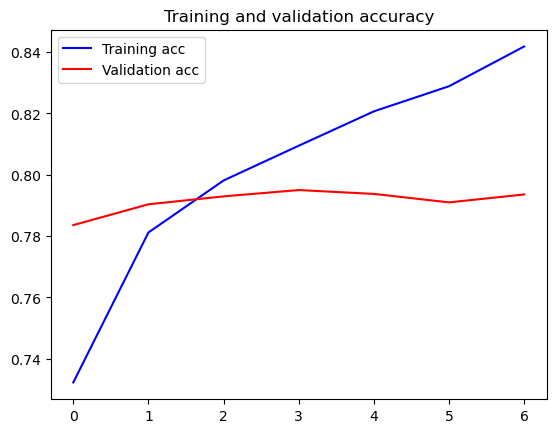

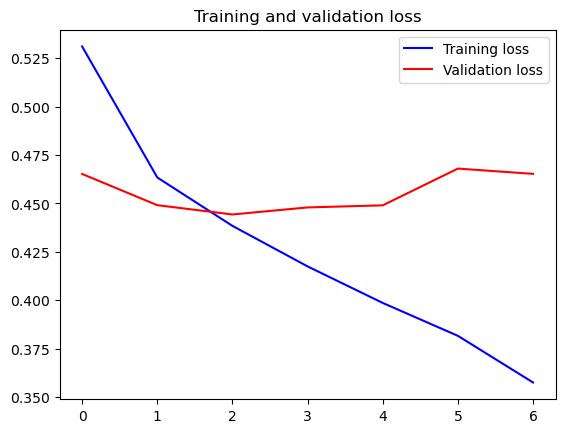

In [549]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [547]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 0
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 1

        
        return label
    else:
        return 0 if score < 0.5 else 1

In [548]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [542]:
predict("I love the music")

1/1 [==============================] - 0s 233ms/step


{'label': 1, 'score': 0.976178765296936, 'elapsed_time': 0.28850817680358887}

In [543]:
predict("I hate the rain")

1/1 [==============================] - 0s 29ms/step


{'label': 0,
 'score': 0.040031544864177704,
 'elapsed_time': 0.061626434326171875}

In [544]:
predict("wow what a pain in the butt")

1/1 [==============================] - 0s 32ms/step


{'label': 0, 'score': 0.38805845379829407, 'elapsed_time': 0.07611751556396484}

Looking at the below output, we can see that the model is not good at understanding the effect of 'not',

when 'not' is used with 'good' it reduces the score, but when used with 'bad' its not increasing the score

what can we do about it ??????????????????????????????????????????????????????????????????????????

In [556]:
print(predict("good"))
print(predict("not good"))
print(predict("not bad"))
print(predict("bad"))
print(predict("not"))

1/1 [==============================] - 0s 295ms/step
{'label': 1, 'score': 0.983025074005127, 'elapsed_time': 0.39402294158935547}
1/1 [==============================] - 0s 42ms/step
{'label': 0, 'score': 0.11910117417573929, 'elapsed_time': 0.07703542709350586}
1/1 [==============================] - 0s 49ms/step
{'label': 1, 'score': 0.5048635005950928, 'elapsed_time': 0.0840003490447998}
1/1 [==============================] - 0s 44ms/step
{'label': 0, 'score': 0.07624607533216476, 'elapsed_time': 0.07721376419067383}
1/1 [==============================] - 0s 46ms/step
{'label': 0, 'score': 0.25964340567588806, 'elapsed_time': 0.0800018310546875}
